The Traveling Salesman Problem (TSP) is a classic combinatorial optimization problem that asks:

“Given a list of cities and the distances between each pair, what is the shortest possible route that visits every city exactly once and returns to the starting point?”

In [1]:
import numpy as np
import cv2 as cv

# Map Generator

In [2]:
class MapGenerator(object):
    def __init__(self, nbr_city, max_distance, coord=None):
        self.nbr_city     = nbr_city
        self.max_distance = max_distance
        if (coord is not None):
            self.coord = coord
        else:
            self.coord = np.random.randint(low=0, high=self.max_distance, size=(self.nbr_city, 2))

    def __call__(self):
        map_of_distance = []
        for point in self.coord:
            tmp_distance = np.linalg.norm(self.coord - point, axis=1)
            #print(tmp_distance)
            map_of_distance.append(tmp_distance)
        return np.array(map_of_distance)

    def __put_points(self, map):
        for x, y in self.coord:
            cv.circle(map, (x, y), 4, (0, 255, 0), -1)

    def putRoutesOnMap(self, routes):
        map = np.zeros((self.max_distance, self.max_distance, 3), dtype=np.uint8)
        self.__put_points(map)

        st_x, st_y = self.coord[routes[0]]
        cv.circle(map, (st_x, st_y), 5, (255, 255, 255), 1)
        for route in routes[1:]:
            en_x, en_y = self.coord[route]
            cv.circle(map, (st_x, st_y), 4, (0, 0, 255), -1)
            cv.line(map,   (st_x, st_y), (en_x, en_y), (255, 0, 0), 4)
            st_x, st_y = en_x, en_y
        cv.circle(map, (st_x, st_y), 8, (0, 255, 255), 1)
        return map


In [3]:
map_generator = MapGenerator(20, 300)
map_of_distance = map_generator()
map_of_distance

array([[  0.        , 260.63959791, 215.56437554, 256.3298656 ,
        286.44720281, 155.66630978, 130.3840481 , 351.4669259 ,
        253.26863209, 304.32219768, 139.01438774, 240.4703724 ,
        181.0690476 , 185.18099255, 253.71243564, 266.32686684,
        333.67798849, 100.2646498 ,  25.07987241, 284.08449447],
       [260.63959791,   0.        , 222.7666941 , 328.61223349,
        206.0218435 , 170.39072745, 151.63442881, 215.39266468,
         21.9544984 ,  72.61542536, 125.22779244, 114.38968485,
         93.30058949, 106.00471688, 322.14437757,  16.2788206 ,
        216.18973149, 181.86808406, 239.65391714, 116.40017182],
       [215.56437554, 222.7666941 ,   0.        , 106.40018797,
         85.08818954,  78.40918314, 122.58874337, 158.77342347,
        201.73497466, 207.57649193, 198.28514821, 115.97413505,
        145.49914089, 124.86793023,  99.80981916, 214.21951358,
        135.98897014, 130.54118124, 215.47389633, 147.52626885],
       [256.3298656 , 328.61223349, 1

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
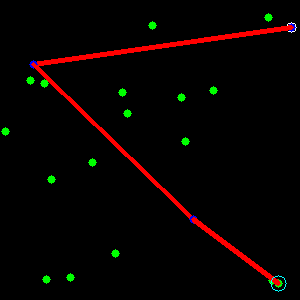

In [4]:
map_img = map_generator.putRoutesOnMap([0, 1, 2 ,3 ])
map_img

In [83]:
map_of_distance = [
    [0, 10, 15, 25],
    [10, 0, 20, 35],
    [15, 20, 0, 30],
    [25, 35, 30, 0]]
map_of_distance = np.array(map_of_distance)

# Genetic Algorithm

## Build Genetic Algorithm

In [5]:
class GeneticAOTSP(object):
    # constante pentru setarea algoritmului
    POPULATION_SIZE = 100 # numarul populatiei
    GENOME_LENGTH   = 4 # numarul de orase
    MUTATION_RATE   = 0.01  # threshold-ul pentru a face o mutatie genetica
    CROSSOVER_RATE  = 0.5   # threshold-ul pentru incrucisarea parintilor
    SELECT_RATE     = 0.8   # threshold-ul de selectie, selectare dupa compatibilitate sau dupa probabilitate
    K_DISTANCE      = 0.1   # coeficientul de pondere a distantei si inhibare a numarului de orase
    K_NBR_CITY      = 0.1   # coeficientul de pondere a distantei si inhibare a numarului de orase
    K_BEST          = 5     # salveaza pentru urmatoarea generatie numarul de indivizi, cu cel mai mare scor
    K_WRONG         = 5     # salveaza pentru urmatoarea generatie numarul de indivizi, cu cel mai mic scor
    GENERATIONS     = 500 # numarul de generatii

    def __init__(self, fitness_fn=None):
        if (fitness_fn is not None):
            self.fitness = fitness_fn
        else:
            self.fitness = self.__fitness

    def __call__(self, distance:"np.array", population=None):
        # save map
        if (distance is not None):
            self.distance = distance
            self.total_distance = np.sum(self.distance, axis=None)
            # update numarul de orase
            GeneticAOTSP.GENOME_LENGTH = self.distance.shape[0]
        else:
            raise NameError("Lipseste 'distance' este un numar null")
        # initiaizarea populatiei
        if (population is None):
            population = self.initPopulation()
        if ((population is None) or (not hasattr(self, "_GeneticAOTSP__min_distance"))):
            print("min_distance")
            self.__min_distance = np.sort(self.distance[0])[1]
        print("population", population)
        self.__prev_min_distance = self.__min_distance
        # init fitness value
        fitness_values = self.fitness(population)
        # obtinerea pozitiei pentru indivizii extrimali
        arg_extreme = self.getKExtreme(fitness_values)

        # evolutia generatiilor
        for generation in range(GeneticAOTSP.GENERATIONS):
            # nasterea unei noi generatii
            new_population = []
            for _ in range(GeneticAOTSP.POPULATION_SIZE-arg_extreme.shape[0]):
                # selectarea parintilor
                arg_parent1 = self.selectParent1(population, fitness_values)
                arg_parent2 = self.selectParent2(population, fitness_values, arg_parent1)
                parent1 = population[arg_parent1]
                parent2 = population[arg_parent2]
                # incrucisarea parintilor
                child = self.crossover(parent1, parent2)
                # mutatii
                child = self.mutate(child)
                new_population.append(child)
            # salvarea indivizilor extrimali
            extreme_population  = population[arg_extreme]
            # schimbarea generatiei
            population = np.array(new_population, dtype=np.int32)
            # integrarea indivizilor extrimali in noua generatie
            population = np.concatenate((population, extreme_population), axis=0)
            # update la valorile fitness
            fitness_values = self.fitness(population)
            # obtinerea pozitiilor pentru indivizii extrimali din noua generatie
            arg_extreme = self.getKExtreme(fitness_values)
            # obtinerea celui mai bun individ
            arg_best = self.getBestRoute(fitness_values)
            # selectarea celei mai bune rute
            best_route = population[arg_best]
            distance = self.getIndividDistance(best_route)
            number_city = self.getIndividNumberCities(best_route)
            # selectarea celei mai mici distante din intreaga populatie
            best_distance = self.getBestDistance(population)
            # selectarea celui mai mare numar de orase din intreaga populatie
            best_number_city = self.getBestNumberCities(population)

            # prezinta metricile
            metric_info ="""Generatia: {}, Distanta: {:.3f}, Numarul oraselor {}, Best Distanta: {:.3f}, Best Numarul oraselor {}, Min distance {:.3f}""".format(
                generation, distance, number_city, best_distance, best_number_city, self.__min_distance)
            print(metric_info)
        return best_route, population

    def initPopulation(self):
        """Initializarea populatiei, cu drumuri aleatorii"""
        size = (GeneticAOTSP.POPULATION_SIZE, GeneticAOTSP.GENOME_LENGTH)
        arr = np.arange(np.prod(size), dtype=np.int32).reshape(*size)%GeneticAOTSP.GENOME_LENGTH
        population = np.apply_along_axis(np.random.permutation, axis=1, arr=arr)
        population[:, -1] = population[:, 0]
        return population

    def selectParent1(self, population, fitness_values):
        """selectarea unui parinte aleator din populatie, bazandune pe distributia fitness valorilor"""
        # select random parent
        prob_fitness = fitness_values / fitness_values.sum()
        #print("selectie aleatorie", prob_fitness)
        arg = np.random.choice(GeneticAOTSP.POPULATION_SIZE, size=None, p=prob_fitness)
        return arg

    def selectParent2(self, population, fitness_values, arg_partener):
        """selectarea unui parinte aleator din populatie"""
        select_rate = np.random.uniform(low=0, high=GeneticAOTSP.SELECT_RATE, size=None)
        if (select_rate < GeneticAOTSP.SELECT_RATE): # selectie dupa compatibilitate
            total_fitness    = np.sum(fitness_values, axis=None)
            fitness_partener = fitness_values[arg_partener]
            pick = np.random.uniform(low=fitness_partener, high=total_fitness, size=None)
            current = 0
            for arg, fitness_value in enumerate(fitness_values, 0):
                current += fitness_value
                if (current > pick):
                    break
        else: # selectie aleatorie
            prob_fitness = fitness_values / fitness_values.sum()
            #print("selectie aleatorie", prob_fitness)
            # selecteaza argumentul parintelui 2
            arg = np.random.choice(GeneticAOTSP.POPULATION_SIZE, size=None, p=prob_fitness)
        return arg

    def crossover(self, parent1, parent2):
        """Incrucisarea a doi parinti pentru a crea un urmas
        """
        # creare un copil fara mostenire
        child = np.zeros(parent1.shape[0])
        # selectarea diapazonului de mostenire
        low   = 1
        hight = parent1.shape[0]-1
        start = np.random.randint(low=low, high=hight, size=None)
        end   = np.random.randint(low=low, high=hight, size=None)
        if (start > end):
            start, end = end, start
        # copierea rutei din primul parinte
        child[start:end] = parent1[start:end]
        # copierea rutei din cel de al doilea parinte
        child[:start] = parent2[:start]
        child[end:]   = parent2[end:]
        return child

    def mutate(self, individ):
        """Mutatia genetica a rutei"""
        # selectarea genomurile care vor fi mutate cu locul
        cond = np.random.uniform(low=0, high=1, size=None)
        if (cond < (GeneticAOTSP.MUTATION_RATE*0.3)):
            low   = 1
            hight = individ.shape[0]-1
            index1 = np.random.randint(low=low, high=hight, size=None)
            index2 = np.random.randint(low=low, high=hight, size=None)
            individ[index1], individ[index2] = individ[index2], individ[index1]
        elif (cond < (GeneticAOTSP.MUTATION_RATE)):
            low   = 1
            hight = individ.shape[0]-1
            index = np.random.randint(low=low, high=hight, size=None)
            gene  = np.random.choice(np.arange(low, hight), size=None)
            individ[index] = gene

        return individ

    def getIndividDistance(self, individ):
        """Calculul distantei rutelor"""
        #print("individ", individ)
        distances = self.distance[individ[:-1], individ[1:]]
        distance = distances.sum() + self.distance[individ[-1], individ[0]]
        return distance

    def getIndividNumberCities(self, individ):
        return np.unique(individ, return_index=False, return_inverse=False, return_counts=False, axis=None).shape[0]

    def getIndividNumberCities(self, individ):
        return np.unique(individ, return_index=False, return_inverse=False, return_counts=False, axis=None).shape[0]

    def neighborFreq(self, individ, gene):
        arg_gene = np.argwhere(individ==gene).reshape(-1)
        if (arg_gene.shape[0]):
            freq = 1
        else:
            diff_gene = np.abs(arg_gene[:-1]-arg_gene[1:])
            nbr_gene  = diff_gene.shape[0]
            neighbor_genes = (diff_gene==1).sum()
            freq = neighbor_genes/nbr_gene
        return freq

    def neighborsFreq(self, individ):
        genes = np.unique(individ, return_index=False, return_inverse=False, return_counts=False, axis=None)
        freq = 0
        for gene in genes:
            freq += self.neighborFreq(individ, gene)
        return freq/individ.shape[0]

    def getBestRoute(self, fitness_values):
        """Cautarea rutei optime din populatie"""
        index = np.argmax(fitness_values, axis=None, keepdims=False)
        return index

    def getBestDistance(self, population):
        # calculeaza distanta
        distances = self.getDistances(population)
        return distances.min()

    def getBestNumberCities(self, population):
        # calculeaza numarul de orase unice
        number_city = self.getNumberCities(population)
        return number_city.max()

    def getKExtreme(self, fitness_values):
        # returneaza pozitiile cu cele mai mari valori
        low=GeneticAOTSP.K_BEST-(GeneticAOTSP.K_BEST//3)
        k_best = np.random.randint(low=low, high=GeneticAOTSP.K_BEST, size=None)
        low=GeneticAOTSP.K_WRONG-(GeneticAOTSP.K_WRONG//3)
        k_wrong = np.random.randint(low=low, high=GeneticAOTSP.K_WRONG, size=None)
        arg_best  = np.argpartition(fitness_values,-k_best)[-k_best:]
        arg_wrong = np.argpartition(fitness_values, k_wrong)[:k_wrong]
        return np.concatenate((arg_best, arg_wrong), axis=0)

    def getDistances(self, population):
        """calcularea distantei pentru fiecare individ din populatiei"""
        return np.apply_along_axis(self.getIndividDistance,
                                        axis=1,
                                        arr=population)

    def getNumberCities(self, population):
        # calculeaza numarul de orase unice
        return np.apply_along_axis(self.getIndividNumberCities,
                                        axis=1,
                                        arr=population)

    def getNeighborFreq(self, population):
        # calculeaza numarul de orase unice
        return np.apply_along_axis(self.neighborsFreq,
                                        axis=1,
                                        arr=population)


    def __fitness(self, population):
        """ valoarea la fitness este inversul distantei dintre orase si un numar cat mai mare de orase vizitate
        - se calculeaza distanta maxima pentru fiecare individ
        - se calculeaza numarul de orase unice
        """
        # calculeaza distanta
        distances = self.getDistances(population)
        # calculeaza numarul de orase unice
        number_city = self.getNumberCities(population)
        # calculeaza frecventa vecinilor unici apropiati
        neighbor_city = self.getNeighborFreq(population)
        #print("neighbor_city", neighbor_city)
        # calculeaza coeficientul
        distances = self.__distance_norm(distances)
        number_city = city_norm(number_city, GeneticAOTSP.GENOME_LENGTH)
        #print("distances: min {:.3f}, max {:.3f}, mean {:.3f}, std {:.3f}, quatile_25 {:.3f}, quatile_50 {:.3f}, quatile_75 {:.3f}".format(distances.min(), distances.max(), np.mean(distances), np.std(distances),
        #                                                          np.quantile(distances, 0.25), np.quantile(distances, 0.5), np.quantile(distances, 0.75)))
        #print("number_city", number_city)
        #print("neighbor_city", neighbor_city)
        fitness_values = GeneticAOTSP.K_DISTANCE*distances + GeneticAOTSP.K_NBR_CITY*number_city*neighbor_city
        return fitness_values

    def setParameters(self, **kw):
        GeneticAOTSP.POPULATION_SIZE = kw.get("POPULATION_SIZE", GeneticAOTSP.POPULATION_SIZE)
        GeneticAOTSP.MUTATION_RATE   = kw.get("MUTATION_RATE", GeneticAOTSP.MUTATION_RATE)
        GeneticAOTSP.CROSSOVER_RATE  = kw.get("CROSSOVER_RATE", GeneticAOTSP.CROSSOVER_RATE)
        GeneticAOTSP.SELECT_RATE     = kw.get("SELECT_RATE", GeneticAOTSP.SELECT_RATE)
        GeneticAOTSP.GENERATIONS     = kw.get("GENERATIONS", GeneticAOTSP.GENERATIONS)
        GeneticAOTSP.K_DISTANCE      = kw.get("K_DISTANCE", GeneticAOTSP.K_DISTANCE)
        GeneticAOTSP.K_NBR_CITY      = kw.get("K_NBR_CITY", GeneticAOTSP.K_NBR_CITY)
        GeneticAOTSP.K_BEST          = kw.get("K_BEST", GeneticAOTSP.K_BEST)
        GeneticAOTSP.K_WRONG         = kw.get("K_WRONG", GeneticAOTSP.K_WRONG)

    def __distance_norm(self, distances):
        #max_distance = distances.max()
        self.__min_distance = self.__min_distance*0.99 + distances.min()*0.01
        return (2*self.__min_distance)/(distances + self.__min_distance)

def city_norm(number_city, size):
    return (number_city-1)/size


## Fit

In [191]:
tsp = GeneticAOTSP()

In [194]:

tsp.setParameters(
    POPULATION_SIZE = 1000,  # numarul populatiei
    MUTATION_RATE   = 0.1,   # threshold-ul pentru a face o mutatie genetica
    CROSSOVER_RATE  = 0.5,   # threshold-ul pentru incrucisarea parintilor
    SELECT_RATE     = 0.7,   # threshold-ul de selectie, selectare dupa compatibilitate sau dupa probabilitate
    K_DISTANCE      = 1.0,   # coeficientul de inhibare a distantei
    K_NBR_CITY      = 0.59,   # coeficientul de inhibare a numarului de orase
    GENERATIONS     = 100,   # numarul de generatii
    K_BEST          = 35,     # salveaza pentru urmatoarea generatie numarul de indivizi, cu cel mai mare scor
    K_WRONG         = 5,     # salveaza pentru urmatoarea generatie numarul de indivizi, cu cel mai mic scor
    )
#population = None
routes, population = tsp(map_of_distance, population)

population [[ 7  4  8 ... 12 13  7]
 [ 7  4 10 ... 12  8  7]
 [ 7  4 10 ... 12  8  7]
 ...
 [16 13  4 ...  9  4 16]
 [16 13  4 ... 12  4 16]
 [16 13  4 ... 12  4 16]]
Generatia: 0, Distanta: 1487.135, Numarul oraselor 19, Best Distanta: 1454.087, Best Numarul oraselor 19, Min distance 885.329
Generatia: 1, Distanta: 1487.135, Numarul oraselor 19, Best Distanta: 1397.027, Best Numarul oraselor 19, Min distance 890.446
Generatia: 2, Distanta: 1487.135, Numarul oraselor 19, Best Distanta: 1357.197, Best Numarul oraselor 19, Min distance 895.114
Generatia: 3, Distanta: 1487.135, Numarul oraselor 19, Best Distanta: 1351.143, Best Numarul oraselor 19, Min distance 899.674
Generatia: 4, Distanta: 1487.135, Numarul oraselor 19, Best Distanta: 1280.736, Best Numarul oraselor 19, Min distance 903.485
Generatia: 5, Distanta: 1487.135, Numarul oraselor 19, Best Distanta: 1347.952, Best Numarul oraselor 19, Min distance 907.929
Generatia: 6, Distanta: 1462.065, Numarul oraselor 19, Best Distanta: 1

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
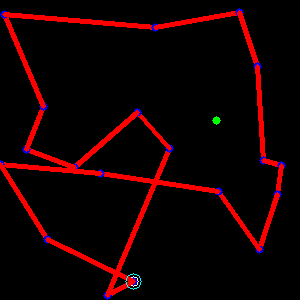

In [193]:
map_generator.putRoutesOnMap(routes)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
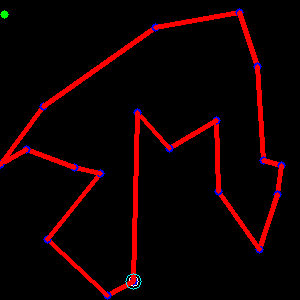

In [195]:
map_generator.putRoutesOnMap(routes)

# Test

In [155]:
def neighbor_freq(individ, gene):
    arg_gene = np.argwhere(individ==gene).reshape(-1)
    diff_gene = np.abs(arg_gene[:-1]-arg_gene[1:])
    nbr_gene  = diff_gene.shape[0]
    neighbor_genes = (diff_gene==1).sum()
    return neighbor_genes/nbr_gene

def neighbors_freq(individ):
    genes = np.unique(individ, return_index=False, return_inverse=False, return_counts=False, axis=None)
    freq = 0
    for gene in genes:
        freq += neighbor_freq(individ, gene)
    return freq


In [156]:
neighbor_freq(individ, unique[0])
neighbors_freq(individ)

np.float64(1.0833333333333333)

In [153]:
individ = np.random.randint(low=0, high=5, size=(20))
print("individ", individ)
unique = np.unique(individ, return_index=False, return_inverse=False, return_counts=False, axis=None)
print("unique", unique)
arg = np.argwhere(individ==unique[0], ).reshape(-1)
#arg = individ==unique[0]
print("arg", arg)
arr = np.abs(arg[:-1]-arg[1:])
print("arr", arr)
nbr_gene = arr.shape[0]
print("nbr_gene", nbr_gene, )
(arr==1).sum()/nbr_gene

individ [0 1 3 0 3 1 1 1 4 2 2 4 2 0 1 3 4 0 0 2]
unique [0 1 2 3 4]
arg [ 0  3 13 17 18]
arr [ 3 10  4  1]
nbr_gene 4


np.float64(0.25)